---

**Lesson 8** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io.wavfile as wav 
import IPython.display as ipd 
import librosa

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)  

#Variational Autoencoder (VAE)

The "Denoising Autoencoder" was robust against noise at its input, the audio signal. The "Variational Autoencoder" (VAE) now is robust against noise in its encoded domain, the "latent representation" in the "latent space".
We introduce a "regularizer" term, which is added to the reconstruction loss function (usually the mean squared error). This is an added term for the loss function, usually with a factor for weighing the importance of the regularizer.

In [2]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [3]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=8*1024, filter length of 2N, but only 32 outputs:
        #for the mean values:
        self.conv1mean=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        #for the standard devieation values:
        self.conv1std=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True)

    def encodermean(self, x):
        #Analysis:
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y
      
    def encoderstd(self, x):
        #Analysis:
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        Yencmean=model.encodermean(x)
        Yencstd=model.encoderstd(x)
        #Yvariational= torch.normal(Yencmean, Yencstd)
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        #for the randn_like see also: https://github.com/pytorch/examples/blob/master/vae/main.py
        Ypred=model.decoder(Yvariational)
        return Ypred, Yencmean, Yencstd

In [4]:
#2 different loss function can be used. Here the 2 definitiom. We choose one of these.

def variational_loss(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    #see also: see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    #https://arxiv.org/abs/1312.6114
    vl=-0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl
   
def variational_loss2(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    #alternative: mean squared distance from ideal mu=0 and std=1:
    vl=torch.mean(mu.pow(2)+(1-std).pow(2))
    return vl

In [25]:
#alternative: speech:
#make training set with batch of 2 speech signals:
batch=2;
#fs, x0= wav.read('./test2.wav') #get size of the speech files, all need to be identical
x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        #fs, x0= wav.read('./audio/test2.wav')
        x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
    if b==1:
        #fs, x0= wav.read('./audio/test3.wav')
        x0, fs = librosa.load("./PRODIGYLOOP.wav", mono=True, sr=None, duration=1, offset=0)
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [26]:
Ypred, Yencmean, Yencstd = model(X)
    
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_variational_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
"""
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
#Ypred=model(X)
#Ypred=Ypred.detach()
#print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

outputlen= 40962
Input X.shape= torch.Size([2, 1, 44100])
Target Y.shape= torch.Size([2, 1, 40962])
Target Y= tensor([[[ 1.0786e-02,  8.0396e-03,  6.7941e-04,  ..., -1.7792e-01,
          -1.4800e-01, -1.0067e-01]],

        [[-1.0804e-04,  2.0095e-03, -1.6422e-03,  ...,  5.4667e-03,
           3.7532e-02,  7.6167e-02]]])
Y.type()= torch.FloatTensor


#Experiment 1
###conventional VAE
We let the program run like a conventional variational autoencoder. In the "for" loop for the training we have:

In [27]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(2000):
        #Ypred, Yencmean, Yencstd = model(X)
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)
          
        #standard deviation values from the network:
        Yencstd=model.encoderstd(X)
        #unit standard deviation:
        #Yencstd=torch.ones(Yencmean.shape)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        vl=variational_loss(Yencmean, Yencstd)
        #vl=variational_loss2(Yencmean, Yencstd) # This will be used on the Experiment 2 later !!!
        loss= mse + 0.01*vl
        #loss= mse 
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""

0 mse= 0.03434745967388153 variational loss= 2.5791850090026855
10 mse= 0.033011142164468765 variational loss= 0.6840794682502747
20 mse= 0.030729355290532112 variational loss= 0.4647541046142578
30 mse= 0.027084633708000183 variational loss= 0.40310314297676086
40 mse= 0.024256262928247452 variational loss= 0.38558468222618103
50 mse= 0.021147215738892555 variational loss= 0.38175269961357117
60 mse= 0.018365448340773582 variational loss= 0.38207483291625977
70 mse= 0.01503254845738411 variational loss= 0.3869251012802124
80 mse= 0.01511302962899208 variational loss= 0.39074793457984924
90 mse= 0.013629444874823093 variational loss= 0.3931327760219574
100 mse= 0.014238264411687851 variational loss= 0.39581361413002014
110 mse= 0.011441187933087349 variational loss= 0.40162166953086853
120 mse= 0.009095592424273491 variational loss= 0.4086442291736603
130 mse= 0.00862911157310009 variational loss= 0.415604829788208
140 mse= 0.008708412759006023 variational loss= 0.4194772243499756
150 

MSE= 0.00360515876673162 Variational Loss: 0.4129718244075775
ww= OrderedDict([('conv1mean.weight', tensor([[[-0.0029, -0.0070,  0.0058,  ...,  0.0008, -0.0037, -0.0034]],

        [[ 0.0002,  0.0018, -0.0085,  ...,  0.0064,  0.0034,  0.0042]],

        [[-0.0096,  0.0032, -0.0045,  ...,  0.0072,  0.0023, -0.0069]],

        ...,

        [[-0.0024,  0.0021, -0.0009,  ..., -0.0060, -0.0042, -0.0044]],

        [[ 0.0023, -0.0005, -0.0013,  ...,  0.0078,  0.0067,  0.0009]],

        [[-0.0077, -0.0009,  0.0021,  ...,  0.0076,  0.0063,  0.0030]]])), ('conv1mean.bias', tensor([-0.0080, -0.0051, -0.0020,  0.0044, -0.0074, -0.0065,  0.0007,  0.0054,
        -0.0035,  0.0008, -0.0030, -0.0070, -0.0059,  0.0012, -0.0080, -0.0010,
         0.0017, -0.0016,  0.0009, -0.0017,  0.0090,  0.0047,  0.0085,  0.0050,
         0.0033,  0.0061, -0.0129,  0.0037,  0.0054, -0.0075,  0.0140, -0.0099])), ('conv1std.weight', tensor([[[-0.0062,  0.0032,  0.0027,  ...,  0.0049,  0.0024,  0.0020]],

        [[ 

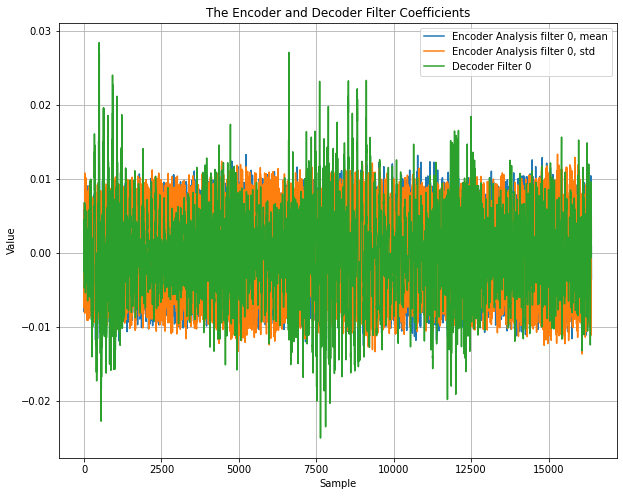

In [28]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

It first lets the autoencoder run on the training set without additional noise, and plays back the result. Observe that it already sounds a little noisy. 

Then it add noise with unit standard deviation (value of 1). Observe that it sounds more noisy. 

In [29]:
#Test on training set:
    
#predictions=model(X).cpu() # Make Predictions based on the obtained weights, on training set
#noisy case:
#predictions, Yencmean, Yencstd = model(X)
Yencmean=model.encodermean(X)
    
#no noise case ******
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)

#noise case ******    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2

Yencstd.shape= (2, 32, 6)
predictions.shape= (2, 1, 40962)


"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


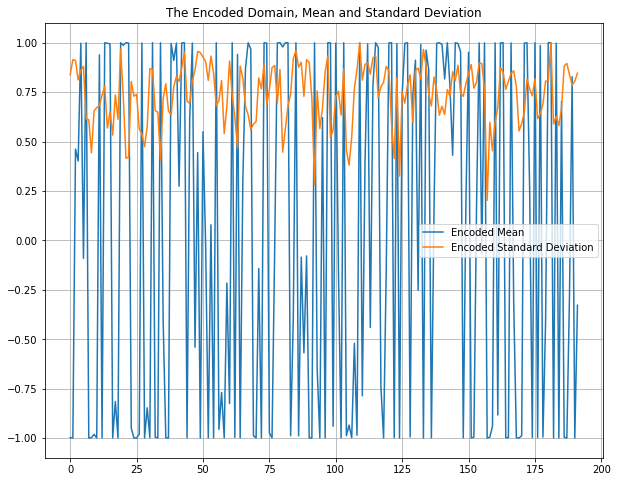

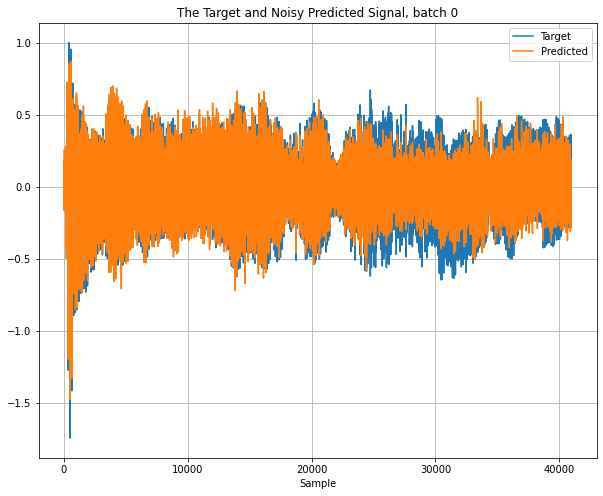

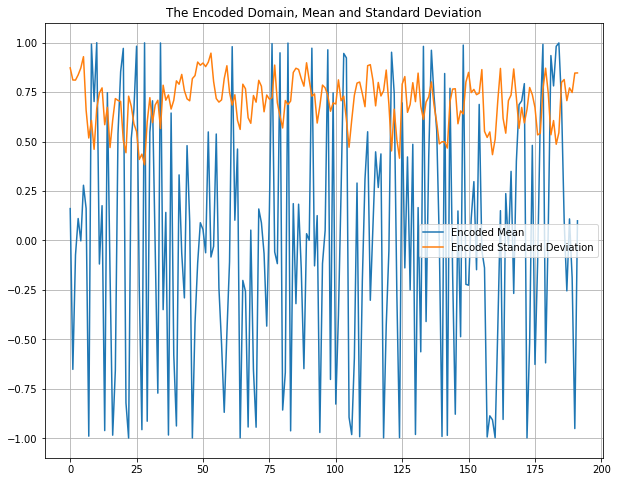

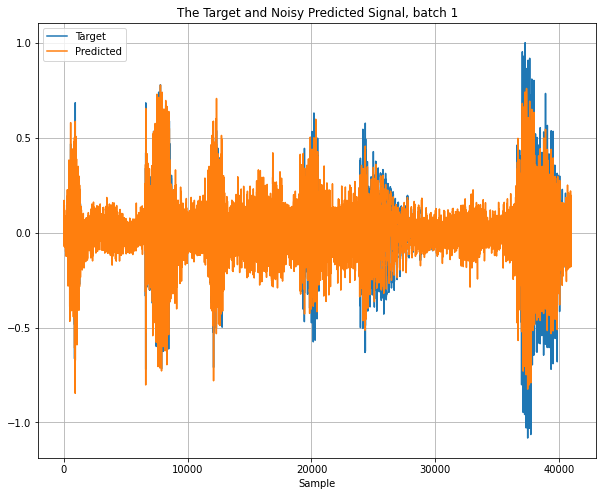

In [30]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    #print("np.reshape(Yencstd[b,:,:],(1,-1))", np.reshape(Yencstd[b,:,:],(1,-1)))
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


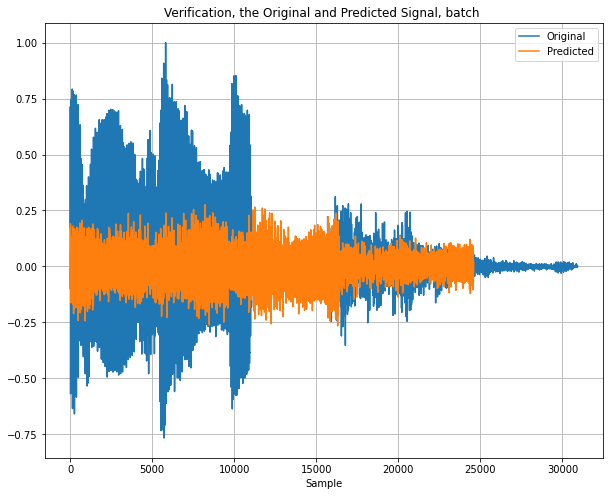

In [36]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=1) #NB i change the offset; it is like a new useen data now
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

#Experiment 2:

Use our alternative variational loss function for the training:

NB. The other part stays the same

In [37]:
#alternative: speech:
#make training set with batch of 2 speech signals:
batch=2;
#fs, x0= wav.read('./audio/test2.wav') #get size of the speech files, all need to be identical
x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        #fs, x0= wav.read('./audio/test2.wav')
        x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
    if b==1:
        #fs, x0= wav.read('./audio/test3.wav')
        x0, fs = librosa.load("./PRODIGYLOOP.wav", mono=True, sr=None, duration=1, offset=0)
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [38]:
Ypred, Yencmean, Yencstd = model(X)
    
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_variational_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
"""
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
#Ypred=model(X)
#Ypred=Ypred.detach()
#print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

outputlen= 40962
Input X.shape= torch.Size([2, 1, 44100])
Target Y.shape= torch.Size([2, 1, 40962])
Target Y= tensor([[[ 1.0786e-02,  8.0396e-03,  6.7941e-04,  ..., -1.7792e-01,
          -1.4800e-01, -1.0067e-01]],

        [[-1.0804e-04,  2.0095e-03, -1.6422e-03,  ...,  5.4667e-03,
           3.7532e-02,  7.6167e-02]]])
Y.type()= torch.FloatTensor


In [39]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(2000):
        #Ypred, Yencmean, Yencstd = model(X)
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)
          
        #standard deviation values from the network:
        Yencstd=model.encoderstd(X)
        #unit standard deviation:
        #Yencstd=torch.ones(Yencmean.shape)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        #vl=variational_loss(Yencmean, Yencstd)
        vl=variational_loss2(Yencmean, Yencstd) # NOW we use this kind of loss ******
        loss= mse + 0.01*vl
        #loss= mse 
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""

0 mse= 0.03434917330741882 variational loss= 0.8643619418144226
10 mse= 0.03405076265335083 variational loss= 0.275664746761322
20 mse= 0.033096201717853546 variational loss= 0.17273378372192383
30 mse= 0.030817586928606033 variational loss= 0.1832861304283142
40 mse= 0.029142208397388458 variational loss= 0.22296901047229767
50 mse= 0.02694401890039444 variational loss= 0.25815141201019287
60 mse= 0.025844942778348923 variational loss= 0.29209309816360474
70 mse= 0.022782545536756516 variational loss= 0.3263484239578247
80 mse= 0.022076323628425598 variational loss= 0.36222681403160095
90 mse= 0.020313823595643044 variational loss= 0.3736765682697296
100 mse= 0.0202720258384943 variational loss= 0.3957553207874298
110 mse= 0.017397064715623856 variational loss= 0.4286545515060425
120 mse= 0.01458115503191948 variational loss= 0.45160841941833496
130 mse= 0.014527368359267712 variational loss= 0.46630147099494934
140 mse= 0.011314346455037594 variational loss= 0.48285412788391113
150 m

MSE= 0.004250577185302973 Variational Loss: 0.4917390048503876
ww= OrderedDict([('conv1mean.weight', tensor([[[-0.0005,  0.0068,  0.0071,  ..., -0.0070, -0.0087, -0.0048]],

        [[ 0.0057, -0.0020, -0.0003,  ...,  0.0017, -0.0063,  0.0066]],

        [[ 0.0039, -0.0003,  0.0056,  ..., -0.0035, -0.0045, -0.0013]],

        ...,

        [[ 0.0045,  0.0030, -0.0005,  ..., -0.0005,  0.0039, -0.0012]],

        [[ 0.0021, -0.0061, -0.0019,  ...,  0.0049, -0.0001, -0.0054]],

        [[ 0.0045,  0.0048, -0.0054,  ..., -0.0011, -0.0082, -0.0063]]])), ('conv1mean.bias', tensor([ 0.0036, -0.0034, -0.0031,  0.0105,  0.0060,  0.0002,  0.0060, -0.0010,
        -0.0024,  0.0031,  0.0013,  0.0039, -0.0011, -0.0017,  0.0020,  0.0007,
        -0.0065, -0.0001, -0.0005,  0.0028, -0.0059,  0.0077, -0.0023, -0.0025,
        -0.0072, -0.0001, -0.0011,  0.0047, -0.0066, -0.0040,  0.0079,  0.0038])), ('conv1std.weight', tensor([[[-5.3306e-03,  3.4632e-03, -1.8311e-03,  ..., -3.3077e-03,
           6.64

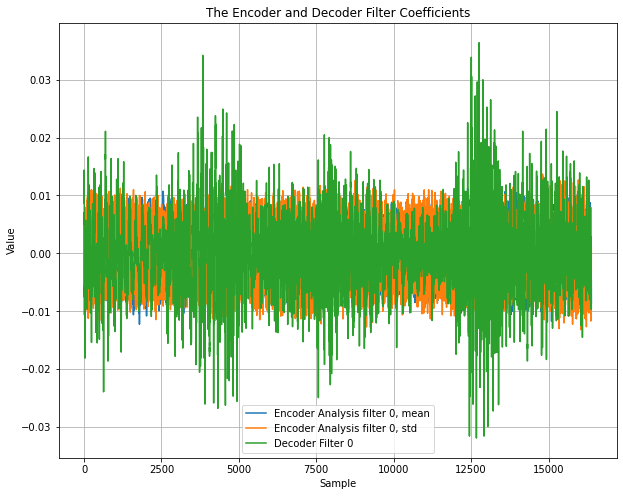

In [40]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [41]:
#Test on training set:
    
#predictions=model(X).cpu() # Make Predictions based on the obtained weights, on training set
#noisy case:
#predictions, Yencmean, Yencstd = model(X)
Yencmean=model.encodermean(X)
    
#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2

Yencstd.shape= (2, 32, 6)
predictions.shape= (2, 1, 40962)


"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


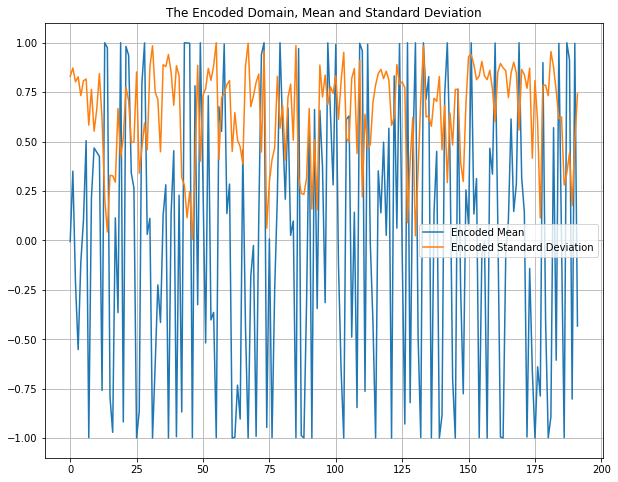

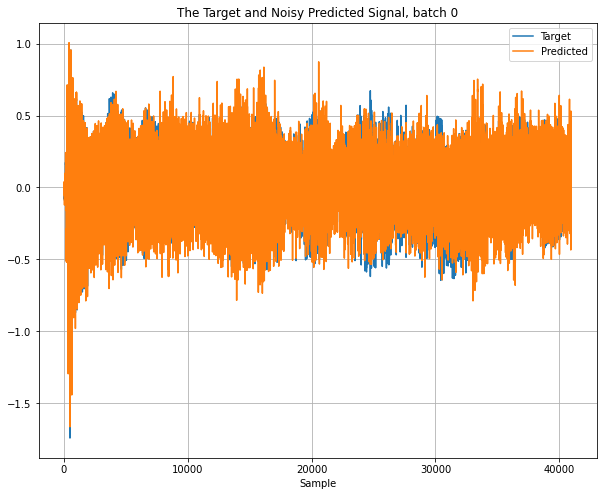

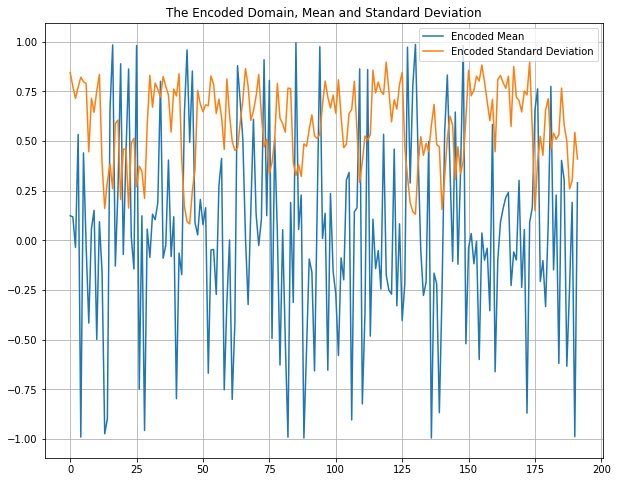

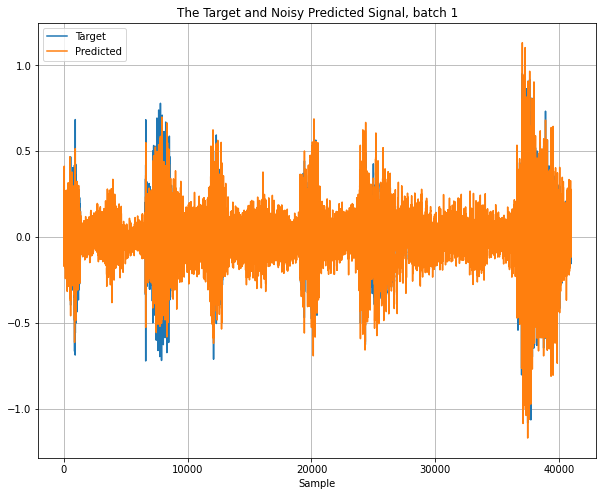

In [42]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    #print("np.reshape(Yencstd[b,:,:],(1,-1))", np.reshape(Yencstd[b,:,:],(1,-1)))
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

Observe the plot of the added noise after training: It is now less close to 1, because this loss "punished" lower noise values less. This means the autoencoder is now more sensitive to noise. Even the "clean" version is not so clean.

The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


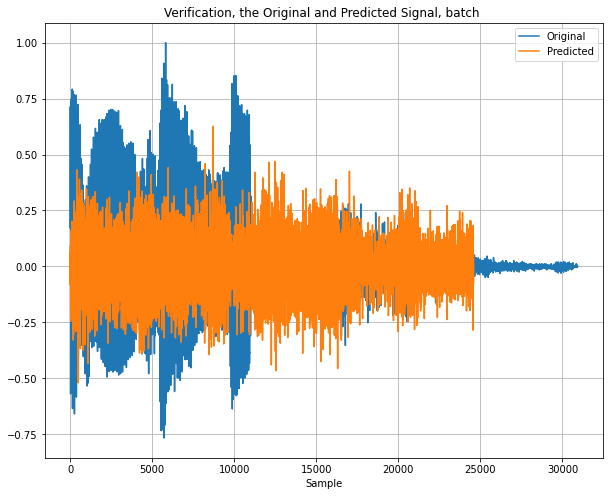

In [43]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=1) #NB i change the offset; it is like a new useen data now
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

#Experiment 3

Use fixed noise with unit standard variance in the training process. This also means we don't need the variational loss anymore, since the added noise is fixed:

aka Lagrange multiplies = 0 in

```
loss= mse + 0.0*vl
```
we have only mss.





In [44]:
#alternative: speech:
#make training set with batch of 2 speech signals:
batch=2;
#fs, x0= wav.read('./audio/test2.wav') #get size of the speech files, all need to be identical
x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        #fs, x0= wav.read('./audio/test2.wav')
        x0, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=0)
    if b==1:
        #fs, x0= wav.read('./audio/test3.wav')
        x0, fs = librosa.load("./PRODIGYLOOP.wav", mono=True, sr=None, duration=1, offset=0)
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 44100)
X.shape= torch.Size([2, 1, 44100])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [45]:
Ypred, Yencmean, Yencstd = model(X)
    
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_variational_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
"""
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
#Ypred=model(X)
#Ypred=Ypred.detach()
#print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

outputlen= 40962
Input X.shape= torch.Size([2, 1, 44100])
Target Y.shape= torch.Size([2, 1, 40962])
Target Y= tensor([[[ 1.0786e-02,  8.0396e-03,  6.7941e-04,  ..., -1.7792e-01,
          -1.4800e-01, -1.0067e-01]],

        [[-1.0804e-04,  2.0095e-03, -1.6422e-03,  ...,  5.4667e-03,
           3.7532e-02,  7.6167e-02]]])
Y.type()= torch.FloatTensor


In [46]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(2000):
        #Ypred, Yencmean, Yencstd = model(X)
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)
          
        #standard deviation values from the network:
        #Yencstd=model.encoderstd(X)
        #unit standard deviation:
        Yencstd=torch.ones(Yencmean.shape) # ****** the std dev have now only ones
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        #vl=variational_loss(Yencmean, Yencstd)
        vl=variational_loss2(Yencmean, Yencstd)
        loss= mse + 0*vl # ******* Langrange multipliers equal to zero
        #loss= mse 
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""
    

0 mse= 0.03565952554345131 variational loss= 0.00980116706341505
10 mse= 0.035025544464588165 variational loss= 0.0770970806479454
20 mse= 0.033026233315467834 variational loss= 0.21411900222301483
30 mse= 0.031448133289813995 variational loss= 0.3454808294773102
40 mse= 0.028944283723831177 variational loss= 0.4476199150085449
50 mse= 0.026224376633763313 variational loss= 0.5285395979881287
60 mse= 0.022776080295443535 variational loss= 0.5905478000640869
70 mse= 0.018824158236384392 variational loss= 0.6451863646507263
80 mse= 0.017854759469628334 variational loss= 0.6940712928771973
90 mse= 0.018342379480600357 variational loss= 0.7357437014579773
100 mse= 0.01530294306576252 variational loss= 0.7709117531776428
110 mse= 0.01420936081558466 variational loss= 0.8013885617256165
120 mse= 0.012611148878932 variational loss= 0.8279687762260437
130 mse= 0.011449508368968964 variational loss= 0.8496179580688477
140 mse= 0.010443705134093761 variational loss= 0.8653027415275574
150 mse= 0

MSE= 0.004234314430505037 Variational Loss: 0.4984927177429199
ww= OrderedDict([('conv1mean.weight', tensor([[[ 8.6501e-03,  6.5718e-03, -4.4678e-03,  ...,  7.7578e-03,
           6.5858e-03,  7.6262e-03]],

        [[ 4.7196e-05, -3.6229e-03,  7.5888e-03,  ..., -1.1744e-02,
          -4.9687e-04, -8.6518e-03]],

        [[-6.4477e-05,  2.6725e-03,  3.9996e-03,  ...,  9.9273e-03,
           1.5130e-02,  1.7482e-02]],

        ...,

        [[-1.0681e-02,  1.2778e-03, -5.1420e-03,  ...,  2.4039e-03,
          -7.0199e-03,  1.6093e-03]],

        [[-7.0961e-03, -1.7354e-02, -1.7552e-02,  ..., -1.4122e-02,
          -4.9118e-03, -2.0248e-02]],

        [[ 3.5770e-05, -2.1713e-03,  3.0333e-03,  ..., -4.7747e-03,
          -9.4051e-03, -6.6358e-03]]])), ('conv1mean.bias', tensor([-0.0157,  0.0047, -0.0031,  0.0103,  0.0035, -0.0030,  0.0059, -0.0102,
        -0.0106, -0.0044, -0.0057,  0.0103, -0.0011, -0.0052,  0.0123, -0.0012,
         0.0089,  0.0011, -0.0185,  0.0039,  0.0021, -0.0164, 

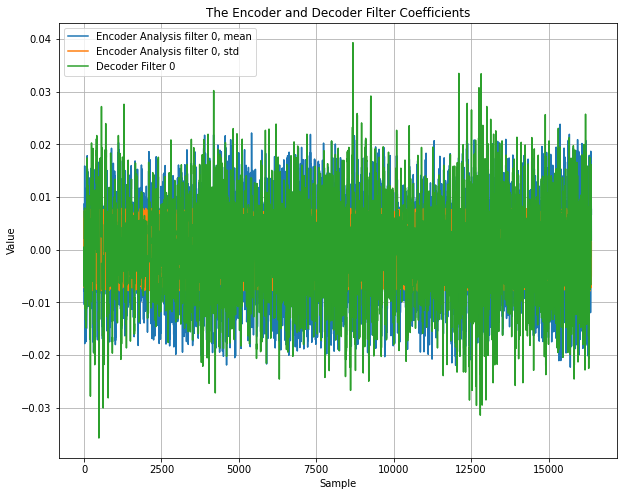

In [47]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [48]:
#Test on training set:
    
#predictions=model(X).cpu() # Make Predictions based on the obtained weights, on training set
#noisy case:
#predictions, Yencmean, Yencstd = model(X)
Yencmean=model.encodermean(X)
    
#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2

Yencstd.shape= (2, 32, 6)
predictions.shape= (2, 1, 40962)


"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


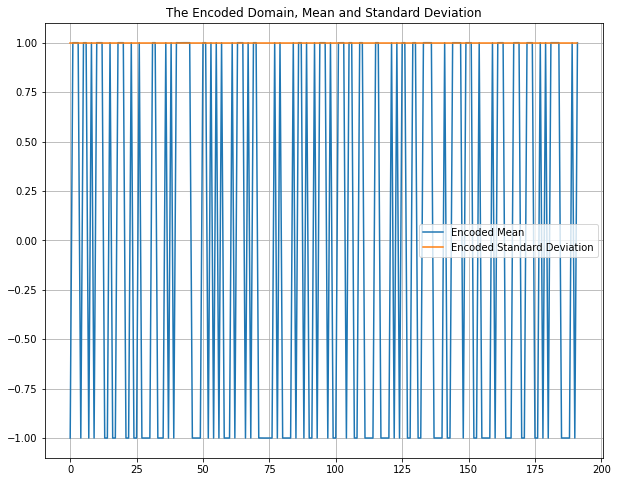

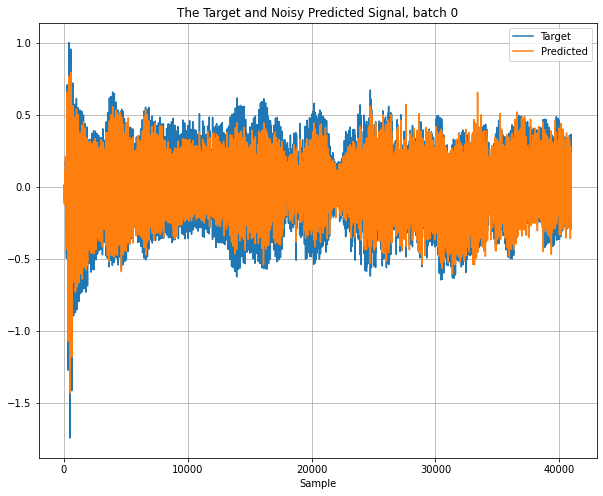

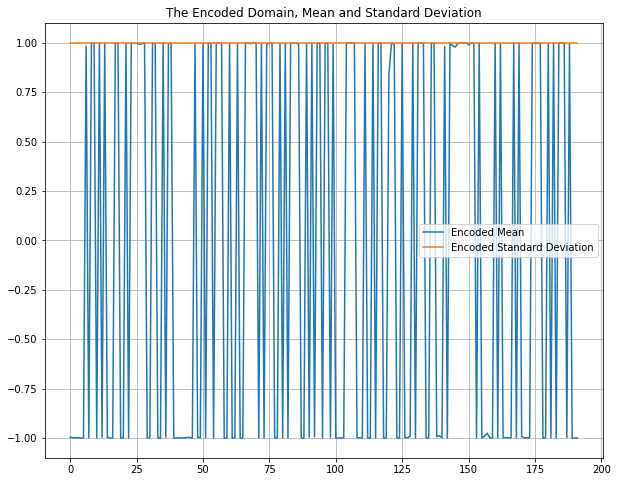

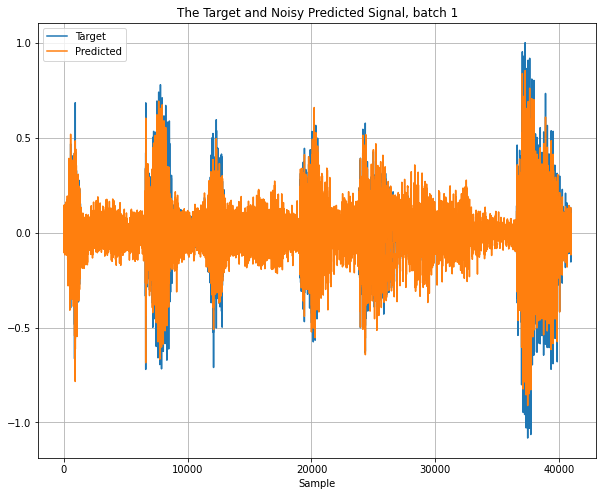

In [49]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    #print("np.reshape(Yencstd[b,:,:],(1,-1))", np.reshape(Yencstd[b,:,:],(1,-1)))
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


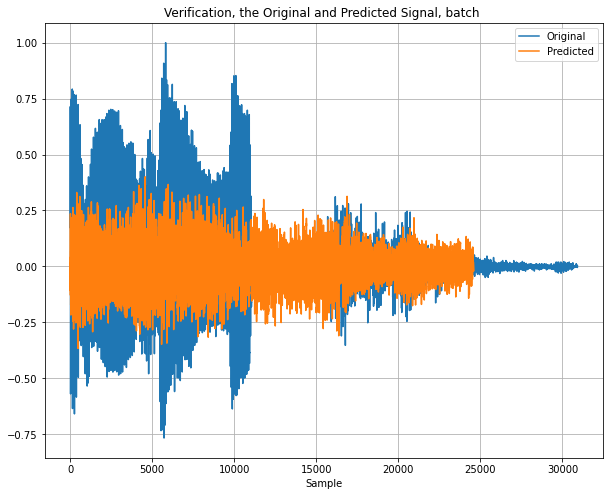

In [50]:
#Test on Verification set:
#fs, x= wav.read('test.wav')
x, fs = librosa.load("./HARSH REALM.wav", mono=True, sr=None, duration=1, offset=1) #NB i change the offset; it is like a new useen data now
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

In this last case, there is no need for a Neural Net for retrieving the STD Deviation !!